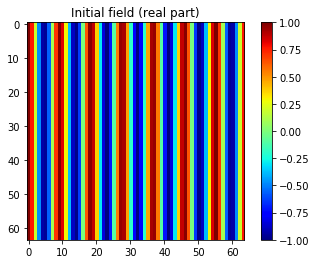

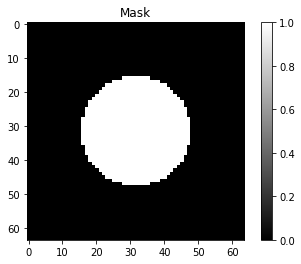

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import copy


def empty_mask(size):
    return np.zeros((size,size))

def circular_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[(x-x0)**2+(y-y0)**2<=r**2]=1
    return M

def rectangle_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[((x-x0)**2<=r**2)*((y-y0)**2<=r**2)]=1
    return M
    

    
def get_plane_wave(E0,k,size):
    y,x = np.mgrid[:size, :size]
    a = np.pi*0/180
    E = E0*np.exp(-1j*k*(x*np.cos(a)+y*np.sin(a)))
    return(E) 
    
def get_greenfun(r,k):
    return (1j/4)*scipy.special.hankel1(0,k*r)

def get_green_matrix(k,size):
    j,i = np.mgrid[:size, :size]
    ij_block = np.sqrt((i-1/2)**2+j**2)
    green_mat = get_greenfun(ij_block,k)
    return green_mat

# def get_toeplitz_mat(ij_block):
#     ij_block = copy.deepcopy(ij_block)
#     T = np.block([[ij_block,ij_block[:,:0:-1]],
#                   [ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]]])
#     return T

def get_toeplitz_mat(ij_block):
    ij_block = copy.deepcopy(ij_block)
    T1 = np.hstack((ij_block,ij_block[:,:0:-1]))
    T2 = np.hstack((ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]))
    T = np.vstack((T1,T2))
    return T
    
def G_matvec(vec,k):
    size = int(np.sqrt(vec.shape[0]))
    G_block = get_green_matrix(k,size)
    G = get_toeplitz_mat(G_block)
    mat = np.zeros((2*size-1,2*size-1),dtype = np.complex64)
    mat_block = vec.reshape((-1,size))
    mat[:size,:size] = mat_block
    out_mat = np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(mat))
    out = out_mat[:size,:size].reshape((-1,1))
    return out


def matvec(x,mask,k,e):
    x = x.reshape((-1,1))
    size = x.shape[0]
    eps = (e-1)*mask.reshape((-1,1))+1
    chi = k**2*(eps - 1)
    return x-G_matvec(x*chi,k)

def visualize(data,title = "",cmap='jet',):
    plt.title(title)
    neg = plt.imshow(data, cmap=cmap, interpolation='none')
    plt.colorbar(neg)
    plt.show()


    
def solve(E,eps0,eps1):
    return E


size = 64
e = 2.25
k  = 2*np.pi/(size/7)
F = get_plane_wave(1,k,size)
visualize(F.real,"Initial field (real part)")
#mask = rectangle_mask(size)
mask = circular_mask(size)
visualize(mask,"Mask","gray")



In [22]:
import scipy.sparse.linalg as spla
import inspect
import time

max_iter = 300
def plot_relstive_residuals_norms(t_with_residuals, relative_vector, delta_t):
    t, residuals = residuals
    plt.semilogy(residuals/np.linalg.norm(relative_vector), label="Generalized Minimal RESidual iterations")
    plt.legend()
    plt.title('Relative residual (depends on time), number of iterations = %i' % len(residuals))
    plt.xlabel('Number of step')
    plt.ylabel('Relative residual norm')
    plt.show()
    
def my_gmres(A, b, x0, maxiter, tol, draw_graph_flag = False):
    gm_residuals = []
    t0 = time.time()
    solution, info =  spla.gmres(A, b,  x0=x0, maxiter = maxiter, tol = tol, restart  = max_iter, callback = lambda x:
        gm_residuals.append([(inspect.currentframe().f_back).f_locals['resid'], time.time()])
        )
    gm_residuals = np.array(gm_residuals).T
    gm_residuals[1] = gm_residuals[1]-t0  
    print("Conv: ",info)
    if (draw_graph_flag == True):
        plot_relstive_residuals_norms(gm_residuals, b, t)
    return solution, info




A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda qwe: matvec(qwe,mask,k,e))
i = 0
b = get_plane_wave(1,k,size).reshape(-1,1)
x0 = np.ones(size**2).reshape(-1,1)

vals, gmres = my_gmres(A, b, x0, maxiter=max_iter, tol=1e-4, draw_graph_flag = True)

vals_re = vals.real.reshape(-1,size)
vals_im = vals.imag.reshape(-1,size)
vals_abs = np.abs(vals).reshape(-1,size)
vals_abs_mask = np.abs(vals).reshape(-1,size)*(1-mask)

print("tol: ",np.linalg.norm(A.dot(vals.reshape(-1,1))-b)/np.linalg.norm(b))
visualize(vals_re,"Real")
visualize(vals_im,"Imag")
visualize(vals_abs,"Abs","gray")
visualize(vals_abs_mask,"Abs with mask")


i=0
toler = 1e-6

TypeError: append() takes exactly one argument (2 given)